## Ch2-2 실습 - 이중분류 - 로지스틱 회귀분석

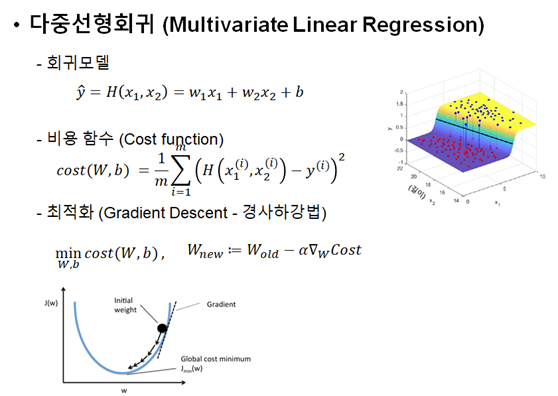

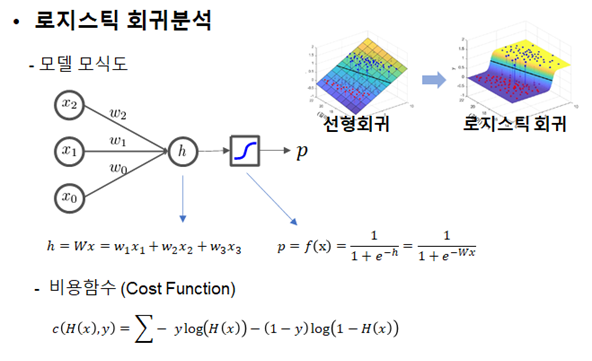

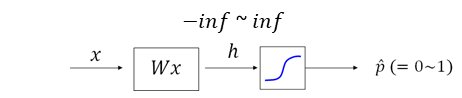

### 다중선형회귀 vs. 로지스틱 회귀분석

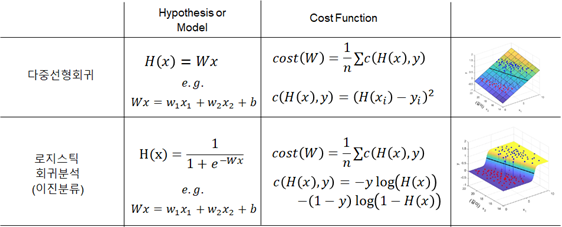

### 실습 - 이중분류 - 로지스틱 회귀분석 

물고기의 길어(x1)와 너비(x2)정보를 바탕으로 물고기의 종류를 예측 하는 모델 개발  
이때, 분류되는 물고기의 종류가 2종인 경우 이중 분류에 해당함
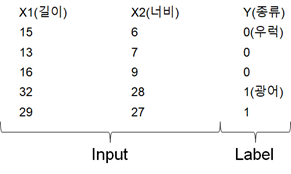

#### 모델 개발 순서

1. 모델 정의 (Linear, Logistic, Multi-nominal)  

2. Cost function 정의 (Mean-squared error (MSE), Binary CrossEntropy, Categorical CrossEntropy)  

3. Cost function을 최소화 하는 방향으로 모델 파라미터 최적화 (Gradient Descent)  
  
    3.1) GradientTape 을 통한 gradient 계산
   
    3.2) $w_{new} = w_{old} - \alpha \nabla cost$을 통한 새로운 w 를 반복적으로 구함.  
      - 해당 계산은 두가지 tensorflow 함수를 통해  계산됨.
      - W.assign_sub($\alpha$ * grad)    
      - optimizer.apply_gradients(zip(grad, [W,b]))  # 사전에 optimizer를 정의하여야함.


### 데이터 생성 및 가시화

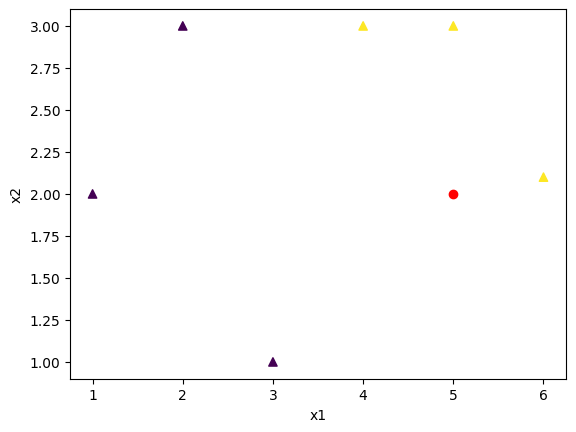

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 랜덤 시드 설정
tf.random.set_seed(0)

# 데이터 생성
x_train = np.array([[1., 2.], [2., 3.], [3., 1.], [4., 3.], [5., 3.], [6., 2.1]], dtype=np.float32)
y_train = np.array([[0.], [0.], [0.], [1.], [1.], [1.]], dtype=np.float32)
x_test = np.array([[5., 2.]], dtype=np.float32)
y_test = np.array([[1.]], dtype=np.float32)

# 훈련 데이터의 각 특성 추출
x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

# 데이터 시각화
colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1, x2, c=colors, marker='^')
plt.scatter(x_test[0][0], x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



### 로지스틱 회귀분석 모델 정의

In [6]:
# 데이터셋 정의
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(len(x_train))

# 가중치와 편향 전역 변수로 정의
W = tf.Variable(tf.random.normal([2, 1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# 모델 정의
def model(x):
    hypothesis = tf.sigmoid(tf.matmul(x, W) + b)  # 시그모이드 함수 사용
    return hypothesis
  
# 손실 함수 정의
def loss_fn(labels, hypothesis):
    cost = - tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

#loss_fn = tf.keras.losses.BinaryCrossentropy()

# 정확도 함수 정의
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

# 옵티마이저 설정
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [7]:
# 훈련 루프
EPOCHS = 1000

for features, labels in dataset:
    print(features, labels)
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_fn(labels, predictions)
        
    grads = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(grads, [W, b]))
#with tf.GradientTape() as tape:
#    predictions = model(x_train)
#    loss = loss_fn(y_train, predictions)

test_accuracy = accuracy_fn(model(x_test), y_test)
print("Test Set Accuracy: {:.4f}".format(test_accuracy))
print("Test Prediction: {:.3f}".format(model(x_test)[0, 0].numpy()))


Test Set Accuracy: 0.0000
Test Prediction: 0.001


### 로지스틱 회귀분석 모델 학습

In [5]:
# 훈련 루프
EPOCHS = 1000
for step in range(EPOCHS):
    for features, labels in dataset:
        with tf.GradientTape() as tape:
            predictions = model(features)
            loss = loss_fn(labels, predictions)
            
        grads = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(grads, [W, b]))
    #with tf.GradientTape() as tape:
    #    predictions = model(x_train)
    #    loss = loss_fn(y_train, predictions)
            
    #grads = tape.gradient(loss, [W, b])
    #optimizer.apply_gradients(zip(grads, [W, b]))
    if (step + 1) % 100 == 0:
        print("Iteration: {:5}, Loss: {:5.4f}".format(step + 1, loss.numpy()))
test_accuracy = accuracy_fn(model(x_test), y_test)
print("Test Set Accuracy: {:.4f}".format(test_accuracy))
print("Test Prediction: {:.3f}".format(model(x_test)[0, 0].numpy()))


Iteration:   100, Loss: 0.4645
Iteration:   200, Loss: 0.4560
Iteration:   300, Loss: 0.4478
Iteration:   400, Loss: 0.4398
Iteration:   500, Loss: 0.4321
Iteration:   600, Loss: 0.4246
Iteration:   700, Loss: 0.4173
Iteration:   800, Loss: 0.4102
Iteration:   900, Loss: 0.4033
Iteration:  1000, Loss: 0.3966
Test Set Accuracy: 1.0000
Test Prediction: 0.886


### 결과 가시화

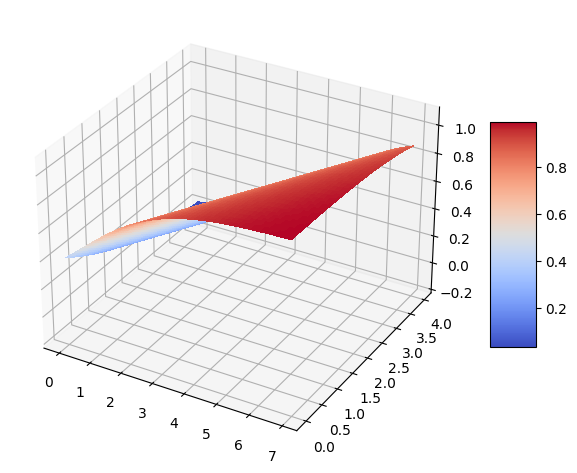

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 3D 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 데이터 생성
x1 = np.arange(0, 7, 0.07)
x2 = np.arange(0, 4, 0.04)
X1, X2 = np.meshgrid(x1, x2)

# 모델 적용
h = model(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))).astype(np.float32))
H = h.numpy().reshape(100, 100)

# 표면 그래프 그리기
surf = ax.plot_surface(X1, X2, H, cmap='coolwarm', linewidth=0, antialiased=False)
ax.set_zlim(-0.2, 1.1)
#ax.view_init(45, 45, -45)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


### 실습. Binary Classification
물고기의 길이(x1)와 너비(x2)정보를 바탕으로 물고기의 종류를 예측 하는 모델 개발  

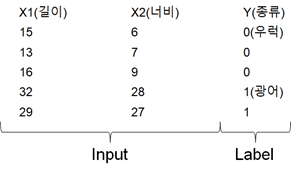